# Recreate the model DOROTHY

### Define the model

In [1]:
import torch
torch.set_num_threads(4)
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim import SGD
import os
import pickle


In [14]:

from torch.optim.lr_scheduler import ReduceLROnPlateau  
from torch.optim.lr_scheduler import CyclicLR  

model = nn.Sequential(
    nn.Flatten(),  # flattens (batch_size, 3, 7650) to (batch_size, 22950)
    nn.Linear(22950, 5000),  # 3 * 7650
    nn.BatchNorm1d(5000),
    nn.GELU(), 
    
    nn.Linear(5000, 2000),
    nn.BatchNorm1d(2000),
    nn.GELU(), 
    
    nn.Linear(2000, 1000),
    nn.BatchNorm1d(1000),
    nn.GELU(),
    
    nn.Linear(1000, 500),
    nn.BatchNorm1d(500),
    nn.GELU(),
    
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.GELU(),
    
    nn.Linear(200, 100),
    nn.BatchNorm1d(100),
    nn.GELU(), 

    nn.Linear(100, 22),
)

s_0 = 0.01

def loss_fn(output, target):
    mu = output[:, :11] #mean
    ln_s = output[:, 11:] #log-scatter
    y = target[:, :11] 
    error = target[:, 11:] 
    s = torch.sqrt(torch.exp(2 * ln_s) + s_0 ** 2)
    loss_value = (mu-y)**2  / (error ** 2 + s ** 2) + torch.log(error ** 2 + s ** 2) 
    return torch.mean(loss_value) 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer=optimizer,
    base_lr=1e-6,
    max_lr=1e-3,
    step_size_up=250,
    step_size_down=650,
    mode="exp_range",
    gamma=0.9995,
    cycle_momentum=False
)

In [3]:
import numpy as np

In [4]:
# Now, we need to load the data
X = np.load('/raid/users/ilaing/MY_RESEARCH/X_loa1108.npy')
y = np.load('/raid/users/ilaing/MY_RESEARCH/y_loa2807.npy')
ids = np.load('/raid/users/ilaing/MY_RESEARCH/apogee_ids_loa1306.npy')

In [5]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
#Before training, we need prepare the data


folder_name = "Masked_DOROTHY_V"
final_path = os.path.join(folder_name, f"Masked_DOROTHY_II_final")
os.makedirs(final_path, exist_ok = True)

# Divide the data into training (70%) and remaining data (30%)
X_train_raw, X_remaining_raw, y_train, y_remaining, ids_train, ids_remaining = train_test_split(
    X, y, ids, train_size = 0.7, shuffle = True, random_state = 42)


# Split the remaining data into validation (20%) and test (10%)
    #Train size will be 0.67 since we want 20% validation of the whole data, not 20% of the remaining data,
    # and the 20% of the whole data corresponds to 67% of the remaining data
X_val_raw, X_test_raw, y_val, y_test, ids_val, ids_test = train_test_split(
    X_remaining_raw, y_remaining, ids_remaining, train_size = 0.67, shuffle = True, random_state = 42) 


# X_train_raw will have a shape (n_samples, 2, 7650), and we will flatten to pass it to the
#       StandardScaler
n_samples, n_channels, n_wavelengths = X_train_raw.shape

#Reshape so it now has a shape (n_samples, 15300)
X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_val_flat = X_val_raw.reshape(X_val_raw.shape[0], -1)
X_test_flat = X_test_raw.reshape(X_test_raw.shape[0], -1)


# Define the scaler
scaler = StandardScaler()
scaler.fit(X_train_flat) # Compute the mean and standard deviation of X_train_flat
#joblib.dump(scaler, os.path.join(final_path, 'scaler.pkl'))

#Now use the scaler transform to use the formula of z = (x-mu)/std to apply the fit to these values
X_train_scaled = scaler.transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)


# Reshape the arrays to 3D for consistency with model inputs:
X_train = X_train_scaled.reshape(X_train_raw.shape[0], n_channels, n_wavelengths)
X_val = X_val_scaled.reshape(X_val_raw.shape[0], n_channels, n_wavelengths)
X_test = X_test_scaled.reshape(X_test_raw.shape[0], n_channels, n_wavelengths)

#Convert to Pytorch tensors:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)

y_train = torch.tensor(y_train, dtype = torch.float)
y_val = torch.tensor(y_val, dtype = torch.float)
y_test = torch.tensor(y_test, dtype = torch.float)

print(len(X_train), len(X_val))


27071 7774


### This cell is the function to create the bitmask

In [6]:
import random
def bitmask(n, percentage, k):
    """Create a bitmask with blocks of 0's
    n: Length of the array
    percentage: Percentage of the array we want with 0's
    k: Length of the blocks of 0's"""

    #Start by creating an array with all 1's
    array = np.ones(n, dtype = int)
    idx = np.linspace(0, n, n, dtype = int, endpoint = False)

    # Define the number of blocks we want
    n_blocks = int(n*percentage) // k

    #Define the number of 0's we want
    zeros_target = int(n_blocks * k)
    total_zeros = 0

    
    idx_replace = np.random.choice(idx, n_blocks, replace = False)
    
    for idx_number in idx_replace:
        for value in idx:
            if value == idx_number:
                for m in range(0, k):
                    if (idx_number + m) >= n:
                        continue

                    if array[idx_number + m] != 0:
                        total_zeros +=1 
                        
                    array[idx_number + m] = 0

    attempts = 0
    while zeros_target != total_zeros:
        idx_new = np.random.choice(idx, 1, replace = True)
        if array[idx_new] == 0:
            attempts += 1
            continue

        if idx_new == n-1:
            array[idx_new] = 0
            total_zeros +=1
        
        if array[idx_new] != 0 and (array[idx_new+1] == 0 or array[idx_new-1] == 0):
            array[idx_new] = 0
            total_zeros +=1
        
    actual_percentage = (1 - sum(array) / n) * 100
    # print(f"Percentage of 0's: {actual_percentage:.1f}%")
    # print(zeros_target, total_zeros)
        
    
    return array

In [15]:
import tqdm
import copy
from math import ceil
import pickle
import os

#Let's define some training parameters first:
epochs = 200
batch_size = 1024
batch_start = np.arange(0, len(X_train), batch_size) 

#Define parameters to keep track of the training and hold the best model
best_loss_value = np.inf #Set the initial loss to be large 
best_weights = None      
lrs = []   #Create a list with all the learning rates
history_train = [] #Create a list with the loss of each epoch when training
history_val = [] #Create a list with the lost of each epoch when validating
avg_grad_norm = []
rng = np.random.default_rng()
save_every = 20


#Start training
for epoch in range(epochs):
    model.train()   #Set the model to training mode
    random_idx = rng.permutation(len(X_train)) #Define random indexes to shuffle the data for each epoch

    #Create a bitmask each epoch!
    mask = bitmask(7650, 0.2, 5)
    mask_tensor = torch.tensor(mask) #Convert to tensor
    mask_bool = torch.tensor(mask.astype(bool)) #Create the mask
    mask_reshaped = mask_tensor.reshape(1, 1, -1) # Reshape to [1, 1, 7650] to add it to X

    X_random = X_train[random_idx].clone()      #Shuffle the Data
    y_random = y_train[random_idx]      #Shuffle the labels with corresponding data

    #Convert masked flux values to 0
    for star in X_random:
        star[0][~mask_bool] = 0
        star[1][~mask_bool] = 0

    
    mask_expanded = mask_reshaped.expand(len(X_random), 1, 7650) # Reshape to [batch_size, 1, 7650] for consistency with X_random
    X_random_masked = torch.cat([X_random, mask_expanded], dim=1) # Add to X_random
    
    epoch_loss_train = 0.0              #Restart the loss value for each epoch
    grad_norm = []
    
    with tqdm.tqdm(batch_start, unit = "batch", desc = f"Epoch {epoch + 1}") as bar:
        for start in bar: #Iterate through each batch
            
            #Get a slice of the size of the batch
            X_batch = X_random_masked[start: start+batch_size]
            y_batch = y_random[start: start+batch_size]

            y_pred = model(X_batch) #Make predictions with first batch
            loss = loss_fn(y_pred, y_batch) #Calculate the loss with the loss function
        
            #Ensure you have a zero gradient before each iteration
            optimizer.zero_grad()
            
            #Do back propagation and store the partial derivatives
            loss.backward()

            total_grad_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_grad_norm += param_norm.item() ** 2
            total_grad_norm = total_grad_norm ** 0.5
            
            # Get the gradient norms of the epoch
            grad_norm.append(total_grad_norm)
            
            #Move in the opposite direction of the gradient (descend)
            optimizer.step()
            scheduler.step()
            
            #Append the learning rates used
            lrs.append(optimizer.param_groups[0]["lr"])  

            #Calculate the total amount of loss in each epoch
            epoch_loss_train += float(loss)
            
            #Add the loss number to the text
            bar.set_postfix(loss_value=float(loss))

    #Determine the mean of the loss in each epoch
    epoch_loss_train /= len(batch_start)
    
    #Append into a list for future plots and analysis
    history_train.append(epoch_loss_train)

    # Get the avg gradient norm of the epoch
    avg_g_norm = sum(grad_norm)/len(grad_norm)
    avg_grad_norm.append(avg_g_norm)
    
    # Validation set evaluation 
    model.eval()
    with torch.no_grad(): #Disable the computation of gradients
        val_mask = torch.tensor(np.ones(7650, dtype = int))
        
        mask_val_reshaped = val_mask.reshape(1, 1, -1)
        mask_val_expanded = mask_val_reshaped.expand(len(X_val), 1, 7650) # Reshape to [batch_size, 1, 7650] for consistency with X_batch
        X_val_masked = torch.cat([X_val, mask_val_expanded], dim=1)
        y_val_pred = model(X_val_masked) #Create a prediction using the validation data
        val_loss_value = loss_fn(y_val_pred, y_val) #Calculate the loss
        history_val.append(val_loss_value) #Append to a list for future plots
   
    # best weight kept
    if val_loss_value < best_loss_value:
        best_loss_value = val_loss_value
        best_weights = copy.deepcopy(model.state_dict()) #Create an independent copy of the weights
        
        
    if epoch % save_every == 0:
        epoch_dir = os.path.join(folder_name, f"epoch_{epoch}")
        os.makedirs(epoch_dir, exist_ok=True)

        torch.save(model.state_dict(), os.path.join(epoch_dir, f'model_epoch_{epoch}.pth'))
        
        torch.save(best_weights, os.path.join(epoch_dir, f'best_model_epoch_{epoch}.pth'))
        
        with open(os.path.join(epoch_dir, 'history_train_val.pkl'), 'wb') as f:
            pickle.dump({'history_train': history_train, 'history_val': history_val}, f)
        
        with open(os.path.join(epoch_dir, 'learning_rates.pkl'), 'wb') as f:
            pickle.dump(lrs, f)
        
    
    print(best_loss_value)

model.load_state_dict(best_weights)

[1 1 1 ... 1 1 1]


Epoch 1: 100%|██████████| 27/27 [00:35<00:00,  1.31s/batch, loss_value=1.23]


tensor(1.3110)
[0 1 1 ... 1 0 0]


Epoch 2: 100%|██████████| 27/27 [00:35<00:00,  1.31s/batch, loss_value=0.863]


tensor(1.3110)
[1 1 1 ... 1 1 0]


Epoch 3: 100%|██████████| 27/27 [00:38<00:00,  1.43s/batch, loss_value=0.804]


tensor(1.3110)
[1 1 1 ... 1 1 1]


Epoch 4: 100%|██████████| 27/27 [00:38<00:00,  1.44s/batch, loss_value=0.459]


tensor(1.3110)
[1 1 1 ... 1 1 1]


Epoch 5: 100%|██████████| 27/27 [00:38<00:00,  1.43s/batch, loss_value=0.159]


tensor(0.4185)
[1 1 1 ... 1 1 0]


Epoch 6: 100%|██████████| 27/27 [00:44<00:00,  1.64s/batch, loss_value=0.187]  


tensor(0.3198)
[0 1 1 ... 0 0 0]


Epoch 7: 100%|██████████| 27/27 [00:44<00:00,  1.63s/batch, loss_value=0.166]   


tensor(0.1439)
[1 1 1 ... 0 0 0]


Epoch 8: 100%|██████████| 27/27 [00:38<00:00,  1.42s/batch, loss_value=-0.106] 


tensor(0.1439)
[1 1 1 ... 1 1 0]


Epoch 9: 100%|██████████| 27/27 [00:36<00:00,  1.35s/batch, loss_value=-0.0607] 


tensor(0.1439)
[1 1 1 ... 1 1 1]


Epoch 10: 100%|██████████| 27/27 [00:39<00:00,  1.45s/batch, loss_value=-0.176] 


tensor(-0.1362)
[0 0 0 ... 1 1 1]


Epoch 11: 100%|██████████| 27/27 [00:40<00:00,  1.51s/batch, loss_value=-0.25] 


tensor(-0.1362)
[1 1 1 ... 1 1 1]


Epoch 12: 100%|██████████| 27/27 [00:42<00:00,  1.56s/batch, loss_value=-0.506]


tensor(-0.1362)
[1 1 1 ... 1 1 0]


Epoch 13: 100%|██████████| 27/27 [00:39<00:00,  1.46s/batch, loss_value=-0.379]


tensor(-0.2895)
[1 1 1 ... 1 1 1]


Epoch 14: 100%|██████████| 27/27 [00:42<00:00,  1.58s/batch, loss_value=-0.456]


tensor(-0.2895)
[1 1 1 ... 1 1 1]


Epoch 15: 100%|██████████| 27/27 [00:41<00:00,  1.54s/batch, loss_value=0.286] 


tensor(-0.2895)
[1 1 1 ... 1 1 1]


Epoch 16: 100%|██████████| 27/27 [00:33<00:00,  1.23s/batch, loss_value=-0.487]


tensor(-0.2895)
[1 1 1 ... 1 1 1]


Epoch 17: 100%|██████████| 27/27 [00:27<00:00,  1.02s/batch, loss_value=-0.637]


tensor(-0.2895)
[1 1 1 ... 1 1 1]


Epoch 18: 100%|██████████| 27/27 [00:34<00:00,  1.26s/batch, loss_value=-0.462]


tensor(-0.4097)
[1 1 1 ... 1 1 1]


Epoch 19: 100%|██████████| 27/27 [00:26<00:00,  1.03batch/s, loss_value=-0.685]


tensor(-0.4097)
[1 1 1 ... 0 0 0]


Epoch 20: 100%|██████████| 27/27 [00:30<00:00,  1.14s/batch, loss_value=-0.458]


tensor(-0.4097)
[1 1 1 ... 1 0 0]


Epoch 21: 100%|██████████| 27/27 [00:39<00:00,  1.46s/batch, loss_value=-0.681]


tensor(-0.4097)
[1 1 1 ... 1 1 1]


Epoch 22:  11%|█         | 3/27 [00:06<00:51,  2.13s/batch, loss_value=-0.514]


KeyboardInterrupt: 

In [19]:
# Now that we have the best model stored in a variable, we will save the model and plot in the directory
import pickle


#"/raid/users/d5martin/Onboarding/MARK_I_pred/MARK_I_pred_final"
torch.save(model.state_dict(), os.path.join(final_path, 'final_model.pth'))
torch.save(best_weights, os.path.join(final_path, "best_model.pth"))

#Save the training history (Note: all files with pkl extension can only be read by using "rb")
with open(os.path.join(final_path, "history_train_val.pkl"), "wb") as f:
    pickle.dump({"history_train": history_train, "history_val": history_val}, f)
    
#Save the validation history
with open(os.path.join(final_path, "learning_rates.pkl"), "wb") as f:
    pickle.dump(lrs, f)

with open(os.path.join(final_path, "grad_norms.pkl"), "wb") as f:
    pickle.dump(avg_grad_norm, f)
    
    

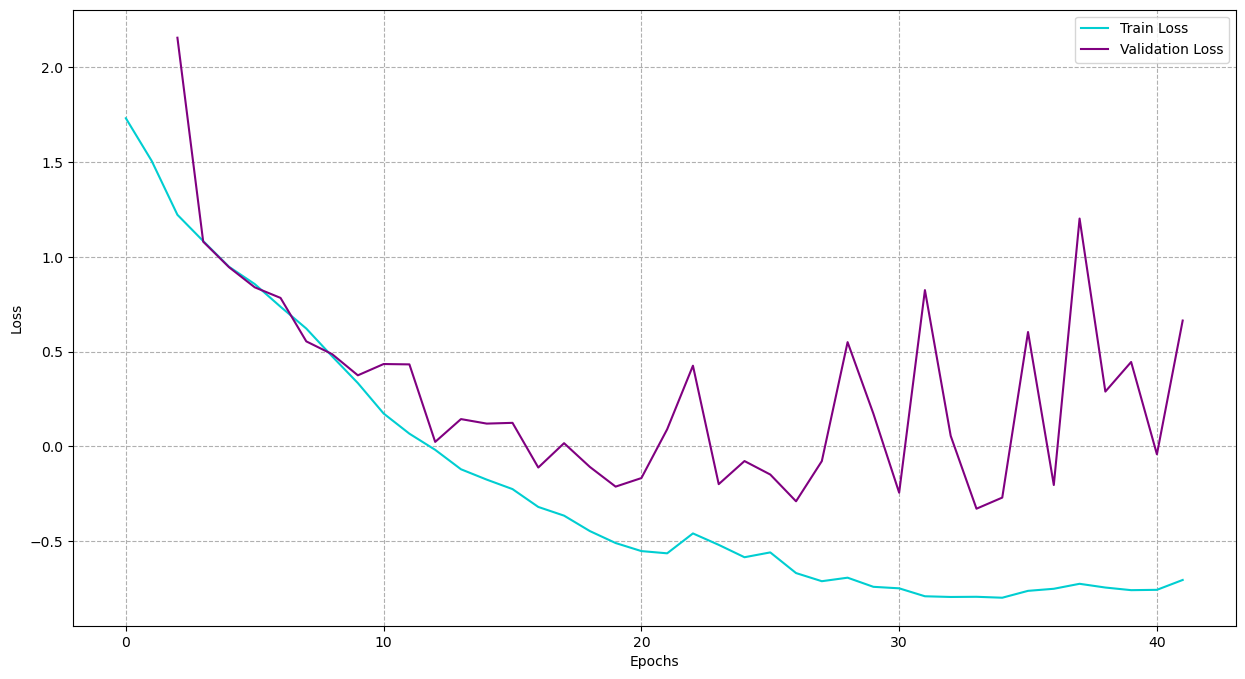

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (15, 8))

ax.plot(history_train, color = "darkturquoise", label = "Train Loss")
ax.plot(history_val, color = "purple", label = "Validation Loss")

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.grid(True, linestyle =  "--")
#plt.ylim(-2, 2)
plt.legend()
plt.show()

In [16]:
#Now we will do our first prediction and compare with the expected result using the test set


model.eval()
with torch.no_grad():
#First do the same process as the validation and training set:

#Flatten
    n_samples, n_channels, n_wavelengths = X_test_raw.shape
    X_test_flat = X_test_raw.reshape(X_test_raw.shape[0], -1) #(N_samples, 15300)

    #Scale
    X_test_scaled_flat = scaler.transform(X_test_flat)

    #Reshape for consistency
    X_test_scaled = X_test_scaled_flat.reshape(X_test_raw.shape[0], n_channels, n_wavelengths)

    #Convert into tensor
    X_test = torch.tensor(X_test_scaled, dtype = torch.float32)
    y_test = torch.tensor(y_test, dtype = torch.float32)


    mask = np.ones(7650, dtype = int)
    mask_test_tensor = torch.tensor(mask) #Convert to tensor
    mask_test_reshaped = mask_test_tensor.reshape(1, 1, -1)
    mask_test_expanded = mask_test_reshaped.expand(len(X_test), 1, 7650) # Reshape to [batch_size, 1, 7650] for consistency with X_batch
    
    X_test_masked = torch.cat([X_test, mask_test_expanded], dim=1)

    y_hat = model(X_test_masked)
    loss_test = loss_fn(y_hat, y_test)
    print(loss_test)
    means = y_hat[:, :11]
    log_scatter = y_hat[:, 11:]
    std_devs = np.exp(log_scatter)

    feh_exp, feh_pred, feh_error = y_test[:, 0].tolist(), means[:, 0].tolist(), std_devs[:, 0].tolist()
    logg_exp, logg_pred, logg_error = y_test[:, 1].tolist(), means[:, 1].tolist(), std_devs[:, 1].tolist()
    teff_exp, teff_pred, teff_error = y_test[:, 2].tolist(), means[:, 2].tolist(), std_devs[:, 2].tolist()
    mgfe_exp, mgfe_pred, mgfe_error = y_test[:, 3].tolist(), means[:, 3].tolist(), std_devs[:, 3].tolist()
    cfe_exp, cfe_pred, cfe_error = y_test[:, 4].tolist(), means[:, 4].tolist(), std_devs[:, 4].tolist()
    sife_exp, sife_pred, sife_error = y_test[:, 5].tolist(), means[:, 5].tolist(), std_devs[:, 5].tolist()
    nife_exp, nife_pred, nife_error = y_test[:, 6].tolist(), means[:, 6].tolist(), std_devs[:, 6].tolist()
    alfe_exp, alfe_pred, alfe_error = y_test[:, 7].tolist(), means[:, 7].tolist(), std_devs[:, 7].tolist()
    cafe_exp, cafe_pred, cafe_error = y_test[:, 8].tolist(), means[:, 8].tolist(), std_devs[:, 8].tolist()
    nfe_exp, nfe_pred, nfe_error = y_test[:, 9].tolist(), means[:, 9].tolist(), std_devs[:, 9].tolist()
    mnfe_exp, mnfe_pred, mnfe_error = y_test[:, 10].tolist(), means[:, 10].tolist(), std_devs[:, 10].tolist()

/tmp/ipykernel_891542/3339822327.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype = torch.float32)


tensor(-0.0498)


In [17]:
feh_exp = np.array(feh_exp)
feh_pred = np.array(feh_pred)
feh_error = np.array(feh_error)

logg_exp = np.array(logg_exp)
logg_pred = np.array(logg_pred)
logg_error = np.array(logg_error)

teff_exp = np.array(teff_exp)
teff_pred = np.array(teff_pred)
teff_error = np.array(teff_error)

mgfe_exp = np.array(mgfe_exp)
mgfe_pred = np.array(mgfe_pred)
mgfe_error = np.array(mgfe_error)

cfe_exp = np.array(cfe_exp)
cfe_pred = np.array(cfe_pred)
cfe_error = np.array(cfe_error)

sife_exp = np.array(sife_exp)
sife_pred = np.array(sife_pred)
sife_error = np.array(sife_error)

nife_exp = np.array(nife_exp)
nife_pred = np.array(nife_pred)
nife_error = np.array(nife_error)

alfe_exp = np.array(alfe_exp)
alfe_pred = np.array(alfe_pred)
alfe_error = np.array(alfe_error)

cafe_exp = np.array(cafe_exp)
cafe_pred = np.array(cafe_pred)
cafe_error = np.array(cafe_error)

nfe_exp = np.array(nfe_exp)
nfe_pred = np.array(nfe_pred)
nfe_error = np.array(nfe_error)

mnfe_exp = np.array(mnfe_exp)
mnfe_pred = np.array(mnfe_pred)
mnfe_error = np.array(mnfe_error)

In [18]:
#FE_H
import pickle

with open("/raid/users/ilaing/MY_RESEARCH/params_loa2807.pkl", "rb") as f:
    params = pickle.load(f)

feh_pred_unnorm = feh_pred * params['feh']['IQR'] + params['feh']['median']
feh_exp_unnorm  = feh_exp  * params['feh']['IQR'] + params['feh']['median']
feh_error_unnorm = feh_error * params['feh']['IQR']

#LOGG
logg_pred_unnorm = logg_pred * params['logg']['IQR'] + params['logg']['median']
logg_exp_unnorm  = logg_exp  * params['logg']['IQR'] + params['logg']['median']
logg_error_unnorm = logg_error * params['logg']['IQR']

#TEFF, note: teff was normalised in log10 space.
log_teff_pred = teff_pred * params['teff']['log_IQR'] + params['teff']['log_median']
teff_pred_unnorm = 10 ** log_teff_pred

log_teff_exp = teff_exp * params['teff']['log_IQR'] + params['teff']['log_median']
teff_exp_unnorm = 10 ** log_teff_exp

log_teff_error = teff_error * params['teff']['log_IQR']
teff_error_unnorm = teff_pred_unnorm * np.log(10) * log_teff_error

#MG_FE
mgfe_pred_unnorm = mgfe_pred * params['mgfe']['IQR'] + params['mgfe']['median']
mgfe_exp_unnorm  = mgfe_exp  * params['mgfe']['IQR'] + params['mgfe']['median']
mgfe_error_unnorm = mgfe_error * params['mgfe']['IQR']

#C_FE
cfe_pred_unnorm = cfe_pred * params['cfe']['IQR'] + params['cfe']['median']
cfe_exp_unnorm  = cfe_exp  * params['cfe']['IQR'] + params['cfe']['median']
cfe_error_unnorm = cfe_error * params['cfe']['IQR']

#SI_FE
sife_pred_unnorm = sife_pred * params['sife']['IQR'] + params['sife']['median']
sife_exp_unnorm  = sife_exp  * params['sife']['IQR'] + params['sife']['median']
sife_error_unnorm = sife_error * params['sife']['IQR']

#NI_FE
nife_pred_unnorm = nife_pred * params['nife']['IQR'] + params['nife']['median']
nife_exp_unnorm  = nife_exp  * params['nife']['IQR'] + params['nife']['median']
nife_error_unnorm = nife_error * params['nife']['IQR']

# AL_FE
alfe_pred_unnorm = alfe_pred * params['alfe']['IQR'] + params['alfe']['median']
alfe_exp_unnorm  = alfe_exp  * params['alfe']['IQR'] + params['alfe']['median']
alfe_error_unnorm = alfe_error * params['alfe']['IQR']

#CA_FE
cafe_pred_unnorm = cafe_pred * params['cafe']['IQR'] + params['cafe']['median']
cafe_exp_unnorm  = cafe_exp  * params['cafe']['IQR'] + params['cafe']['median']
cafe_error_unnorm = cafe_error * params['cafe']['IQR']

#N_FE
nfe_pred_unnorm = nfe_pred * params['nfe']['IQR'] + params['nfe']['median']
nfe_exp_unnorm  = nfe_exp  * params['nfe']['IQR'] + params['nfe']['median']
nfe_error_unnorm = nfe_error * params['nfe']['IQR']

#MN_FE
mnfe_pred_unnorm = mnfe_pred * params['mnfe']['IQR'] + params['mnfe']['median']
mnfe_exp_unnorm  = mnfe_exp  * params['mnfe']['IQR'] + params['mnfe']['median']
mnfe_error_unnorm = mnfe_error * params['mnfe']['IQR']

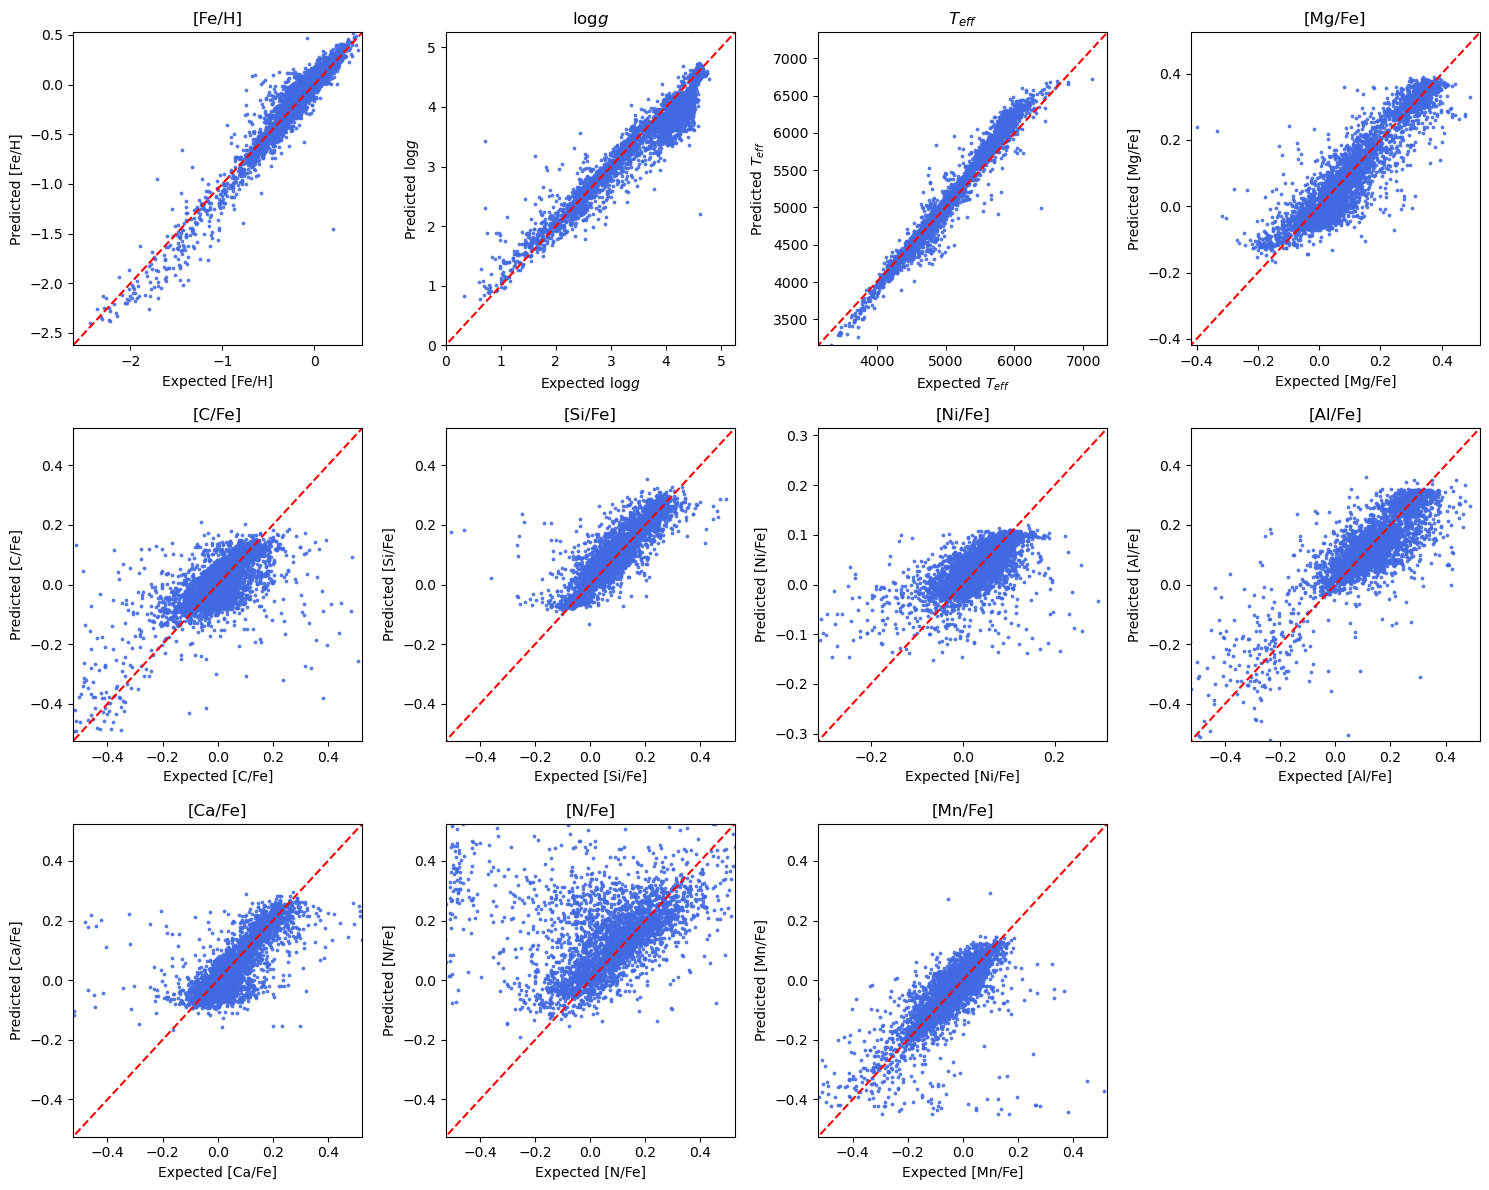

In [21]:
from scipy.stats import mode
feh = [feh_pred_unnorm, feh_exp_unnorm, "[Fe/H]", -2.5, 0.5]
logg = [logg_pred_unnorm, logg_exp_unnorm, "log$g$", 0, 5]
teff = [teff_pred_unnorm, teff_exp_unnorm, "$T_{eff}$", 3000, 7000]
mgfe = [mgfe_pred_unnorm, mgfe_exp_unnorm, "[Mg/Fe]", -0.4, 0.5]
cfe = [cfe_pred_unnorm, cfe_exp_unnorm, "[C/Fe]", -0.5, 0.5]
sife = [sife_pred_unnorm, sife_exp_unnorm, "[Si/Fe]", -0.5, 0.5]
nife = [nife_pred_unnorm, nife_exp_unnorm, "[Ni/Fe]", -0.3, 0.3]
alfe = [alfe_pred_unnorm, alfe_exp_unnorm, "[Al/Fe]", -0.5, 0.5]
cafe = [cafe_pred_unnorm, cafe_exp_unnorm, "[Ca/Fe]", -0.5, 0.5]
nfe = [nfe_pred_unnorm, nfe_exp_unnorm, "[N/Fe]", -0.5, 0.5]
mnfe = [mnfe_pred_unnorm, mnfe_exp_unnorm, "[Mn/Fe]", -0.5, 0.5]

param_limits = {
    "FEH_PRED": (-2.5, 0.5),
    "LOGG_PRED": (0, 7),
    "TEFF_PRED": (3000, 8000),
    "MGFE_PRED": (-0.5, 0.5),
    "CFE_PRED": (-0.5, 0.5),
    "SIFE_PRED": (-0.5, 0.5),
    "NIFE_PRED": (-0.5, 0.5),
    "ALFE_PRED": (-0.5, 0.5),
    "CAFE_PRED": (-0.5, 0.5),
    "NFE_PRED": (-0.5, 0.5),
    "MNFE_PRED": (-0.5, 0.5)
}



stellar_par = [feh, logg, teff, mgfe, cfe, sife, nife, alfe, cafe, nfe, mnfe]

fig, ax = plt.subplots(3, 4, figsize = (15, 12))
ax = ax.flatten()


for i, par in enumerate(stellar_par):
    exp = par[1]
    pred = par[0]

    mode_result = mode(exp, nan_policy='omit')
    mode_val = np.atleast_1d(mode_result.mode)[0] if mode_result.count.size > 0 else np.nan

    mask = (exp != mode_val) & np.isfinite(exp) & np.isfinite(pred)
    exp_masked = exp[mask]
    pred_masked = pred[mask]
    
    ax[i].scatter(exp_masked, pred_masked, s = 3, alpha = 0.8, color = "royalblue")
    ax[i].set_xlabel(f"Expected {par[2]}")
    ax[i].set_ylabel(f"Predicted {par[2]}")
    ax[i].set_title(par[2])
    ax[i].plot(np.linspace(-10000, 10000), np.linspace(-10000, 10000), linestyle = "--", color = "red")
    ax[i].set_xlim(par[3]*1.05, par[4]*1.05)
    ax[i].set_ylim(par[3]*1.05, par[4]*1.05)
    
for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])
        
    
plt.tight_layout()
    

In [22]:
import numpy as np
import pandas as pd
from scipy.stats import mode

def create_performance_tables(preds, errs, exps):
    """
    Compute performance statistics for all available data.

    Args:
        preds (dict): predicted values keyed by parameter
        errs (dict): predicted uncertainties keyed by parameter
        exps (dict): expected/APOGEE values keyed by parameter

    Returns:
        dict: statistics DataFrames keyed by 'all_data'
    """
    params = list(preds.keys())

    def rmse_fn(obs, exp):
        return np.sqrt(np.mean((obs - exp) ** 2))

    def get_stats(pred, exp, err):
        res = pred - exp
        return {
            "Median model error":       np.median(np.abs(err)),
            "Median absolute residual": np.median(np.abs(res)),
            "Mean absolute residual":   np.mean(np.abs(res)),
            "Mean residual":            np.mean(res),
            "Standard deviation":       np.std(res),
            "RMSE":                     rmse_fn(exp, pred),
            "IQR of residuals":         np.percentile(res, 75) - np.percentile(res, 25)
        }

    stats_dict = {}
    for param in params:
        exp = np.array(exps[param])
        pred = np.array(preds[param])
        err = np.array(errs[param])

        # remove mode and NaNs/infs
        mode_val = np.atleast_1d(mode(exp, nan_policy='omit').mode)[0]
        valid = (exp != mode_val) & np.isfinite(exp) & np.isfinite(pred) & np.isfinite(err)
        exp_final = exp[valid]
        pred_final = pred[valid]
        err_final = err[valid]
        
        if len(exp_final) == 0:
            print(f"Warning: No valid data for {param}")
            continue

        stats_dict[param] = get_stats(pred_final, exp_final, err_final)

    # convert to DataFrame
    df_stats = pd.DataFrame(stats_dict)
    all_stats = df_stats

    return all_stats

In [23]:
preds = {
    '[Fe/H]': feh_pred_unnorm,
    'log $g$': logg_pred_unnorm,
    '$T_{eff}$': teff_pred_unnorm,
    '[Mg/Fe]': mgfe_pred_unnorm,
    '[C/Fe]': cfe_pred_unnorm,
    '[Si/Fe]': sife_pred_unnorm,
    '[Ni/Fe]': nife_pred_unnorm,
    '[Al/Fe]': alfe_pred_unnorm,
    '[Ca/Fe]': cafe_pred_unnorm,
    '[N/Fe]': nfe_pred_unnorm,
    '[Mn/Fe]': mnfe_pred_unnorm
}

exps = {
    '[Fe/H]': feh_exp_unnorm,
    'log $g$': logg_exp_unnorm,
    '$T_{eff}$': teff_exp_unnorm,
    '[Mg/Fe]': mgfe_exp_unnorm,
    '[C/Fe]': cfe_exp_unnorm,
    '[Si/Fe]': sife_exp_unnorm,
    '[Ni/Fe]': nife_exp_unnorm,
    '[Al/Fe]': alfe_exp_unnorm,
    '[Ca/Fe]': cafe_exp_unnorm,
    '[N/Fe]': nfe_exp_unnorm,
    '[Mn/Fe]': mnfe_exp_unnorm
}

errs = {
    '[Fe/H]': feh_error_unnorm,
    'log $g$': logg_error_unnorm,
    '$T_{eff}$': teff_error_unnorm,
    '[Mg/Fe]': mgfe_error_unnorm,
    '[C/Fe]': cfe_error_unnorm,
    '[Si/Fe]': sife_error_unnorm,
    '[Ni/Fe]': nife_error_unnorm,
    '[Al/Fe]': alfe_error_unnorm,
    '[Ca/Fe]': cafe_error_unnorm,
    '[N/Fe]': nfe_error_unnorm,
    '[Mn/Fe]': mnfe_error_unnorm
}

table = all_results = create_performance_tables(
    preds=preds, 
    errs=errs, 
    exps=exps,
)

In [24]:
table

,[Fe/H],log $g$,$T_{eff}$,[Mg/Fe],[C/Fe],[Si/Fe],[Ni/Fe],[Al/Fe],[Ca/Fe],[N/Fe],[Mn/Fe]
Median model error,0.055677,0.109884,55.702135,0.034575,0.038839,0.029539,0.030393,0.055205,0.033422,0.088051,0.038023
Median absolute residual,0.056100,0.105953,71.116098,0.031716,0.038017,0.025540,0.024032,0.040826,0.028147,0.064150,0.029167
Mean absolute residual,0.079078,0.175514,109.414529,0.043084,0.060385,0.036919,0.036714,0.058889,0.046701,0.132071,0.048493
Mean residual,0.008189,-0.088027,50.689687,-0.004416,0.002501,0.011223,0.003776,-0.003603,-0.008051,0.059359,0.002547
Standard deviation,0.117688,0.244987,149.417661,0.061627,0.106394,0.055687,0.065663,0.087371,0.085908,0.220352,0.099350
RMSE,0.117973,0.260322,157.781754,0.061785,0.106423,0.056807,0.065771,0.087446,0.086285,0.228207,0.099382
IQR of residuals,0.113064,0.240148,154.326064,0.064562,0.075992,0.050591,0.047986,0.081644,0.056225,0.140735,0.058692


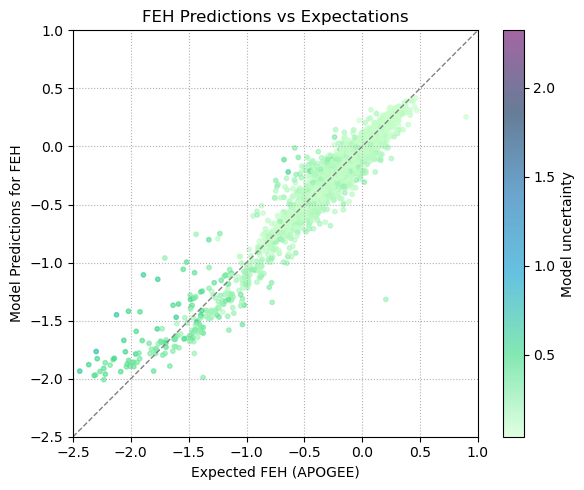

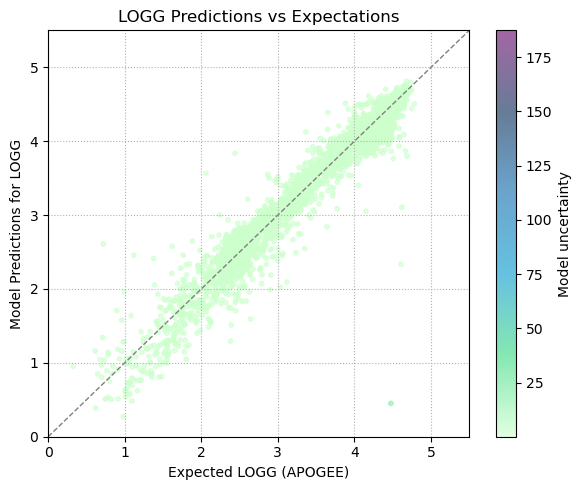

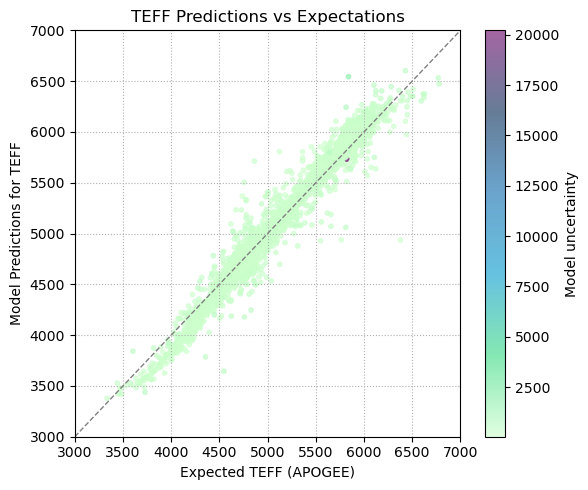

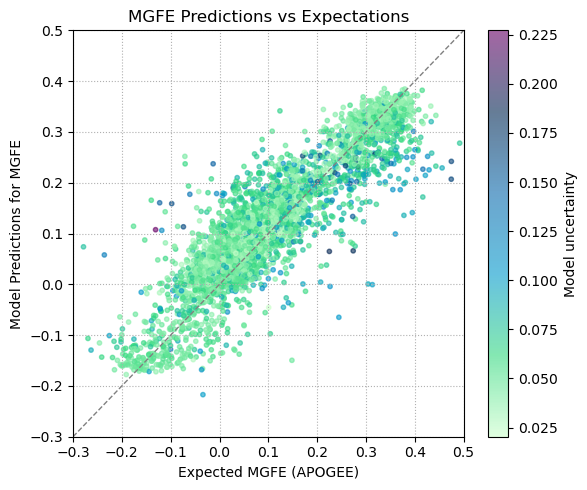

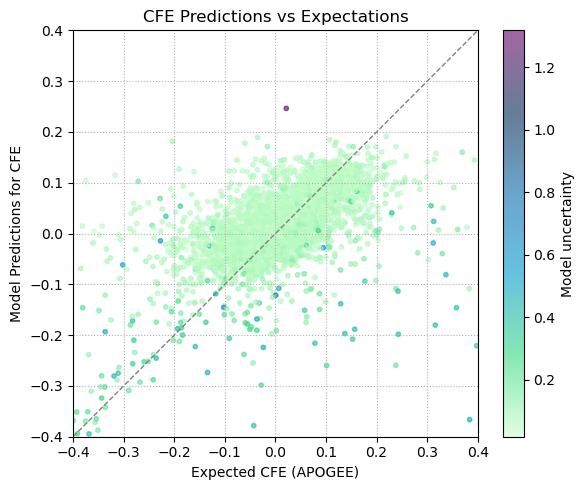

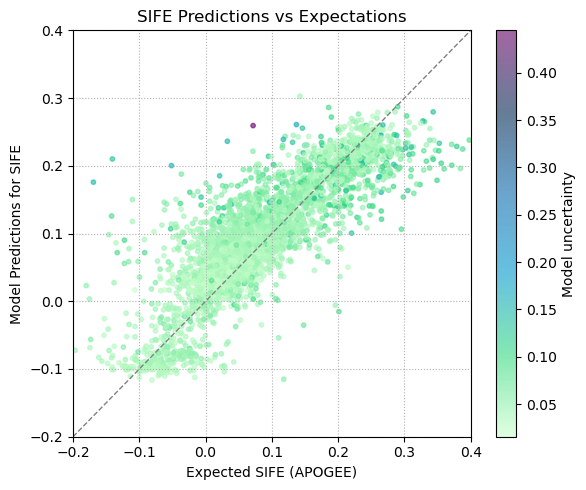

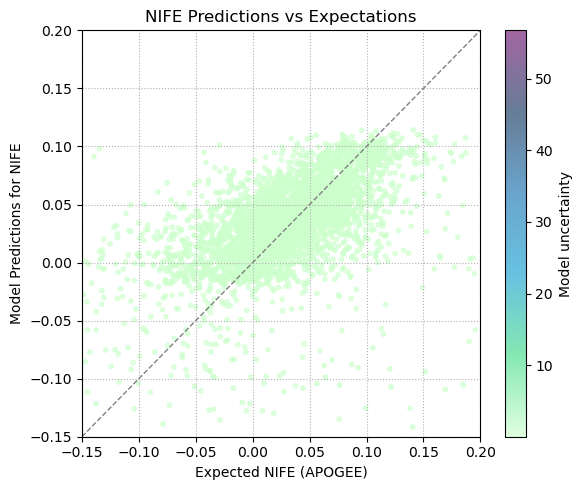

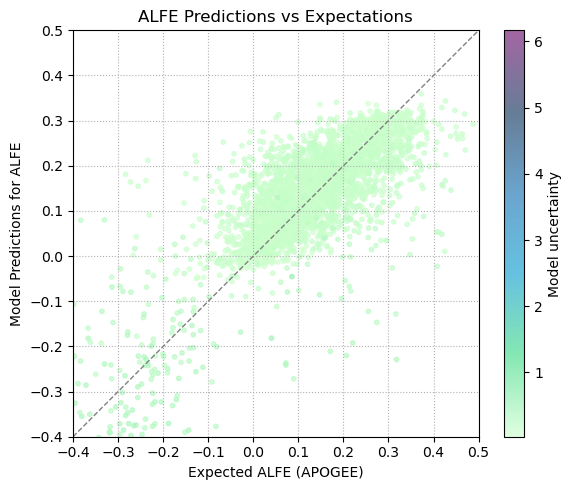

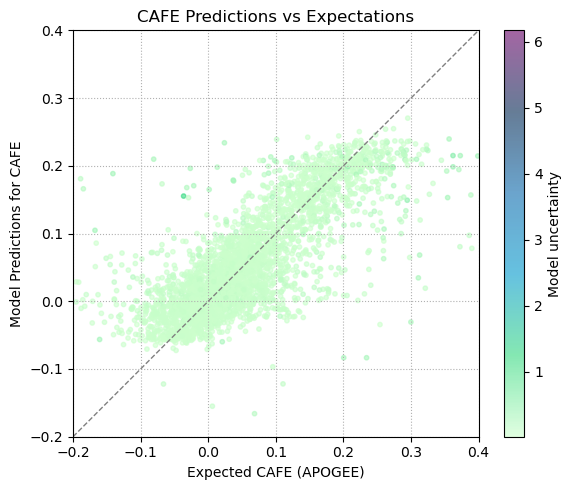

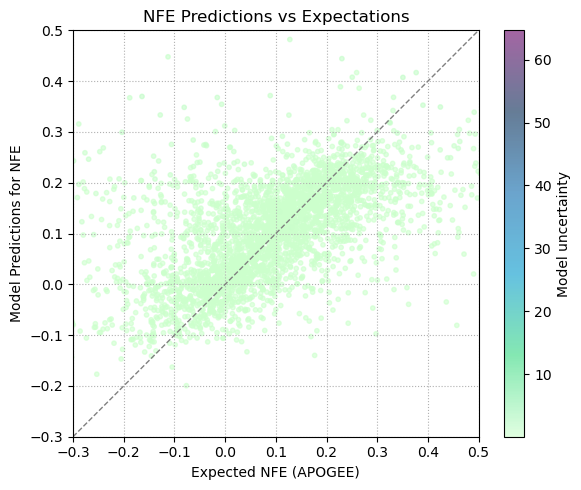

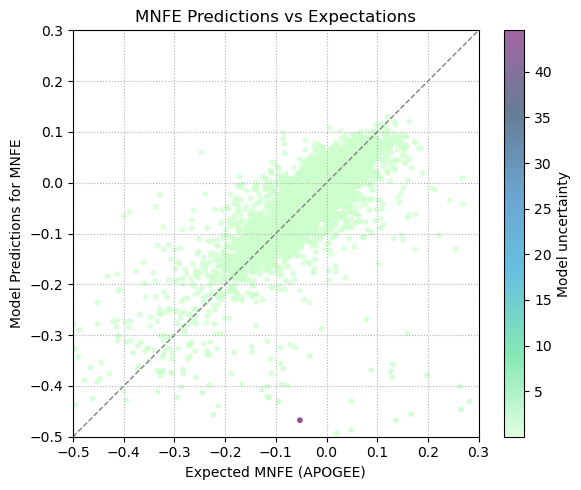

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import os


from matplotlib.colors import LinearSegmentedColormap

colours = [
    (0.8, 1.0, 0.8),           # CCFFCC
    (0.2, 0.85, 0.5),          # 33D980
    (0.0, 0.6, 0.8),           # 0099CC
    (0.0314, 0.4078, 0.6745),  # 0868AC
    (0.0, 0.1490, 0.3176),     # 002651
    (0.4, 0.0, 0.4)            # 660066
]



cmap = LinearSegmentedColormap.from_list("my_cmap", colours, N=256)


for param in params:
    exp = np.array(globals()[f'{param}_exp_unnorm'])
    pred = np.array(globals()[f'{param}_pred_unnorm'])
    err  = np.array(globals()[f'{param}_error_unnorm']) 

    # Exclude fill values (e.g. mode)
    mode_result = mode(exp, nan_policy='omit')
    mode_val = np.atleast_1d(mode_result.mode)[0] if mode_result.count.size > 0 else np.nan

    mask = (exp != mode_val) & np.isfinite(exp) & np.isfinite(pred) & np.isfinite(err)
    exp_masked = exp[mask]
    pred_masked = pred[mask]
    err_masked  = err[mask]

    x_min, x_max = custom_ranges[param]['scatter']
    rangey = [x_min, x_max]

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(exp_masked, pred_masked, s=10, alpha=0.6, c=err_masked, cmap=cmap)
    plt.plot(rangey, rangey, linestyle='--', color='grey', linewidth=1)
    plt.xlabel(f"Expected {param.upper()} (APOGEE)")
    plt.ylabel(f"Model Predictions for {param.upper()}")
    plt.xlim(rangey)
    plt.ylim(rangey)
    plt.title(f"{param.upper()} Predictions vs Expectations")
    plt.grid(True, linestyle=':')
    plt.colorbar(sc, label="Model uncertainty")
    plt.tight_layout()
    

    plt.show()

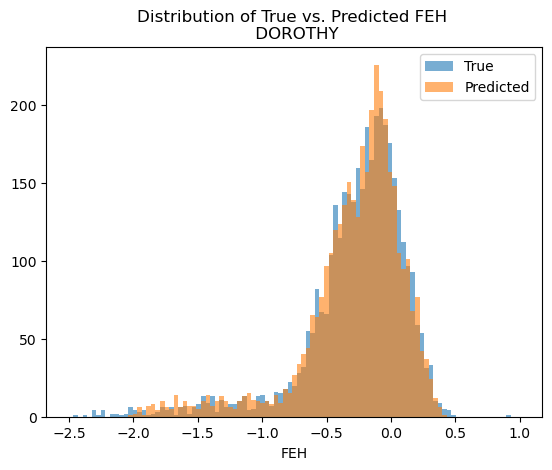

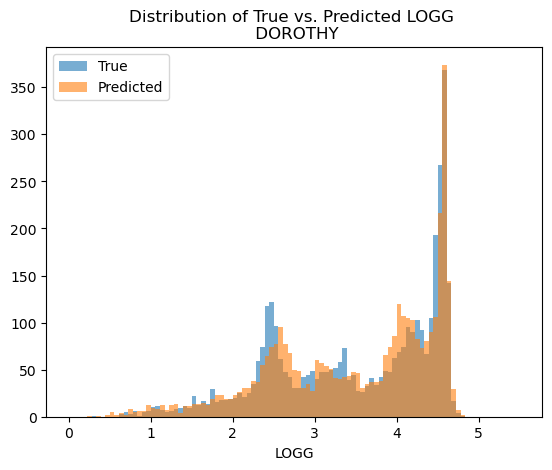

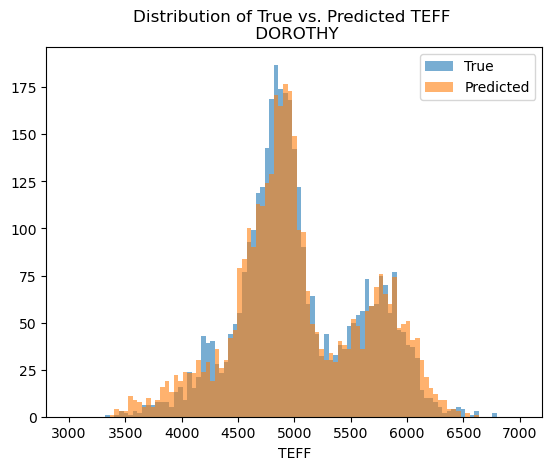

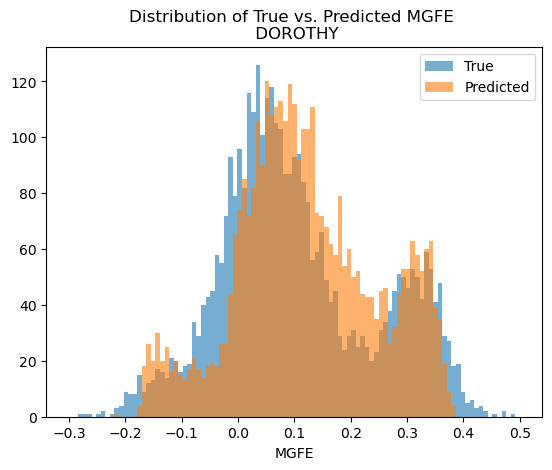

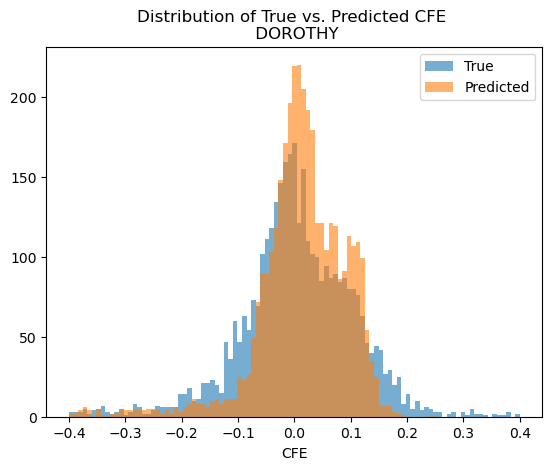

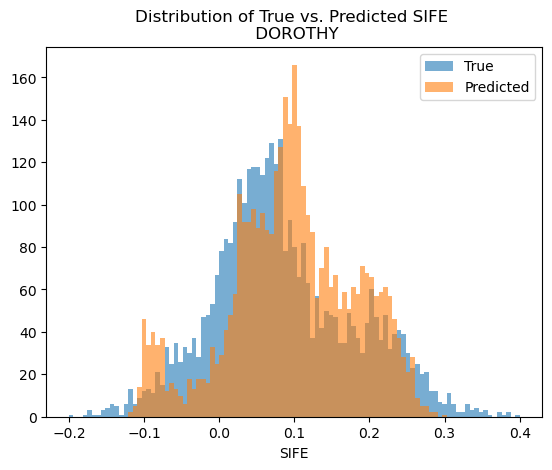

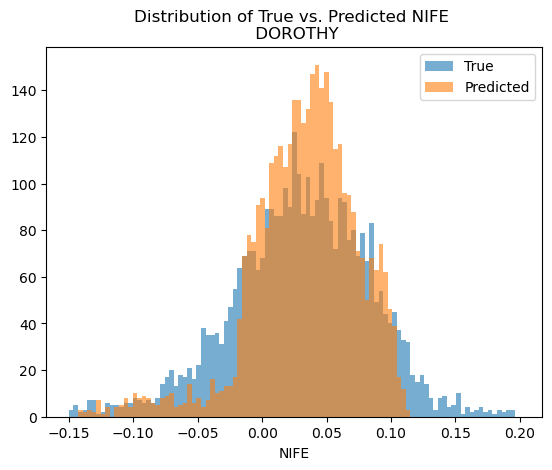

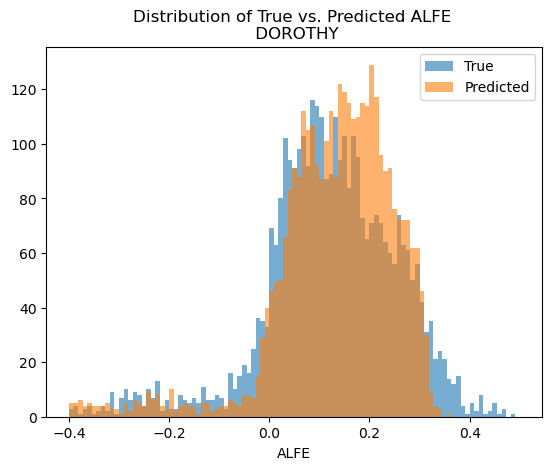

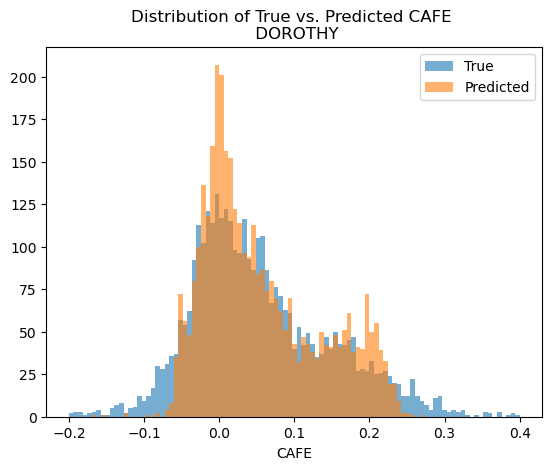

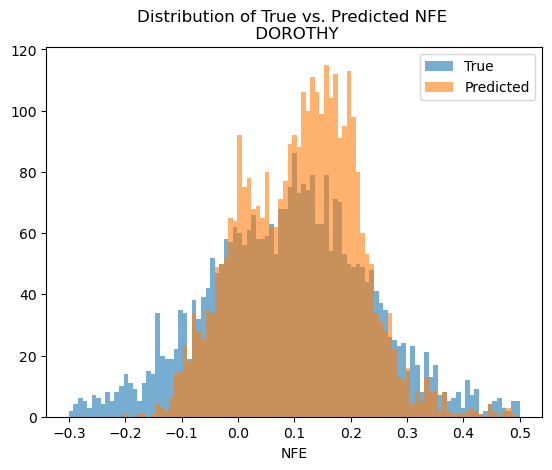

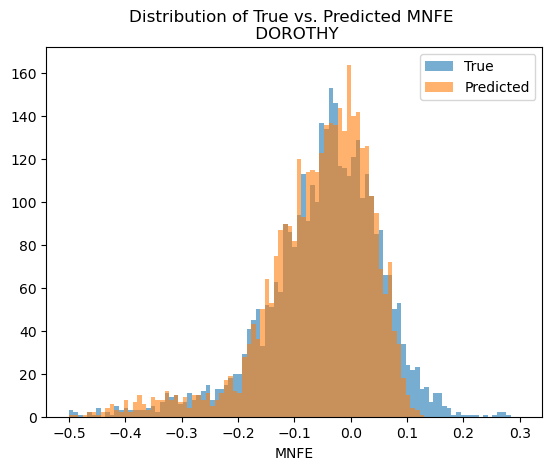

In [23]:
import scipy.stats as ss

for param in params:
    exp = np.array(globals()[f'{param}_exp_unnorm'])
    pred = np.array(globals()[f'{param}_pred_unnorm'])

    # exclude mode (fill value)
    mode_result = mode(exp, nan_policy='omit')
    mode_val = np.atleast_1d(mode_result.mode)[0] if mode_result.count.size > 0 else np.nan

    mask = (exp != mode_val) & np.isfinite(exp) & np.isfinite(pred)
    exp_masked = exp[mask]
    pred_masked = pred[mask]

    x_min, x_max = custom_ranges[param]['scatter']
    range_x = [x_min, x_max]
    
    import numpy as np
    x_min, x_max = custom_ranges[param]['scatter']
    bins = np.linspace(x_min, x_max, 100)
    plt.hist(exp_masked, bins=bins, alpha=0.6, label="True")
    plt.hist(pred_masked, bins=bins, alpha=0.6, label="Predicted")
    plt.legend()

    plt.xlabel(f"{param.upper()}")
    plt.title(f"Distribution of True vs. Predicted {param.upper()} \n DOROTHY")
    plt.show()
